# **Adversarial training for robustness**


We provide here a simple example of how adversarial traning can be used to increase the robustness of the system against adversarial attacks. 

The aim of this notebook will be to teach a neural network to solve a standard image recognition task, in the presence of adversarial attacks. Here, we will:
1. Train a convolutional neural network on the standard MNIST dataset. 
2. Create adversarial examples and test the performance of the network on these.
3. Retrain our model using an the Projected Gradient Descent (PGD) algorithm to iteratively create adversarial examples
4. Re-evaluate performance on the original test set and the adversarial test set

We will implement the neural network in [PyTorch](https://pytorch.org/), and we will use the [Adversarial Robustness Toolbox](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/) library for  adversarial attacks and training.


---

*Some of the computation in this notebook may take some time. If you would like to re-run it, we strongly recommend using Colab's GPU. Go to* Runtime > Change Runtime type > Hardware accelerator > GPU. 

## **Import modules, install ART and load the dataset**

> Indented block



In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

!pip install adversarial-robustness-toolbox

from art.estimators.classification import PyTorchClassifier
from art.utils import load_dataset

In [ ]:
#Load the MNIST dataset
(X_train, y_train), (X_test, y_test), min_value, max_value = load_dataset('mnist')

#Reshape to match PyTorch format
X_train = np.transpose(X_train, (0, 3, 1, 2)).astype(np.float32)
X_test = np.transpose(X_test, (0, 3, 1, 2)).astype(np.float32)

## **Create and train the neural network**

We choose a simple convolutional neural network here, with two convolutional layers, max pooling, ReLU activation functions and dropout. We will then instantiate the model and use the ART classifier wrapper to train the network.

In [ ]:
#Define the neural network model as a class
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv_1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.conv_2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5)
        self.conv_2_drop = nn.Dropout2d()  #Dropout
        self.fc_1 = nn.Linear(in_features=320, out_features=100)
        self.fc_2 = nn.Linear(in_features=100, out_features=10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/ReLU Activation
        x = F.relu(F.max_pool2d(self.conv_1(x), 2)) 
        
        #Convolutional Layer/Dropout/Pooling Layer/ReLU Activation
        x = F.relu(F.max_pool2d(self.conv_2_drop(self.conv_2(x)), 2))
        x = x.view(-1, 320)
        x = self.conv_2_drop(F.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x


#Create the model
model = Network()

#Create the ART classifier
classifier = PyTorchClassifier(
    model=model,
    clip_values=(min_value, max_value),
    loss=nn.CrossEntropyLoss(),
    optimizer=optim.Adam(model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
)

#Train the neural network using the ART package
classifier.fit(X_train, y_train, batch_size=64, nb_epochs=3)


## **Evaluate the performance of the network**

In [ ]:
#Define a function to calculate accuracy
def calculate_accuracy(X, y):
  prediction = np.argmax(classifier.predict(X), axis=1)
  label = np.argmax(y_test, axis=1)
  accuracy = np.mean(prediction == label, axis=0) 
  return accuracy, prediction 

#Calculate accuracy on the test set 
accuracy_test, prediction_test = calculate_accuracy(X_test, y_test)
print("Accuracy on test set: {}%".format(accuracy_test * 100))

Accuracy on test set: 96.66%


As we can see, our neural network has learned to solve the task to a satisfactory degree.

## **Generate adversarial examples and evaluate the performance of the model**

In order to test the robustness of the network against adversarial examples, we take the test set and perturb it slightly (eps=0.2) using the [Projected Gradient Descent](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#projected-gradient-descent-pgd-pytorch) algorithm. We pick this  algorithm because it is a standard one for adversarial training, but other options are available in the  art.accacks.evasion module of the ART package (e.g. [Fast Gradient Method](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#fast-gradient-method-fgm) , [Basic Iterative Method](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/attacks/evasion.html#basic-iterative-method-bim) ,... ).

In [ ]:
from art.attacks.evasion import ProjectedGradientDescentPyTorch

#Generate adversarial examples from test set
attack = ProjectedGradientDescentPyTorch(estimator=classifier, eps=0.2)
X_adv_test = attack.generate(x=X_test)

#Evaluate performance on the test set 
accuracy_adv_test, prediction_adv_test = calculate_accuracy(X_adv_test, y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv_test * 100))

PGD - Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 1.67%


The performance of our model drops catastrophically when we evaluate it on the adversarial test set. 
We will now visually inspect a few samples from the test set, and the performance of the model.

## **Visually inspect adversarial examples**

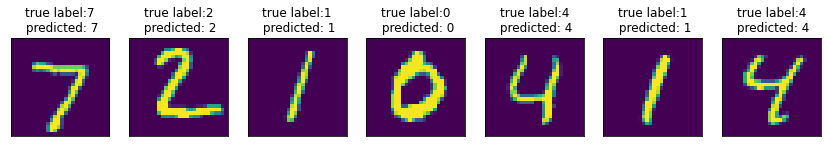

In [ ]:
#Define a function to display the first 7 examples from the dataset
def display_example(X, y, pred):
    n_samples = 7
    for i in range(n_samples):
        img = X[i].reshape(28, 28)
        plt.subplot(101 + n_samples*10 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title('true label:' + str(np.argmax(y[i])) + '\n predicted: ' + str(pred[i]))
        plt.subplots_adjust(right=2)

# Display examples from the original test set, together with the true and predicted labels
display_example(X_test, y_test, prediction_test)

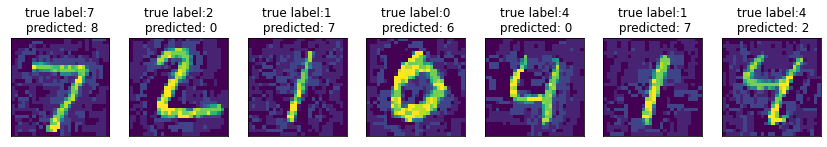

In [ ]:
#Display examples from the adversarial test set, together with the true and predicted labels
display_example(X_adv_test, y_test, prediction_adv_test)

We can see that the adversarial exampels have been perturbed to a degree which is visible to the human eye, yet the digits appear entirely recognizable. The network, however, fails to predict most of these images correctly. 

## **Retrain the network using PGD**

We will now retrain the model using the [Projected Gradient Descent](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#adversarial-training-madry-pgd)(PGD) algorithm. The PGD algoritm iteratively generates adversarial examples for each batch during training. Other types of tranings are available on the art.defence.trainer module of the ART package (e.g. [Adversarial Training Fast is Better than Free](https://adversarial-robustness-toolbox.readthedocs.io/en/latest/modules/defences/trainer.html#adversarial-training-fast-is-better-than-free-pytorch)). 




---



*Please note that running the model may require some time (approx. 2 hours using Colab's GPU).*


In [ ]:
from art.defences.trainer import AdversarialTrainerMadryPGD

#Retrain the model using PGD on the training set 
train_adv_model = AdversarialTrainerMadryPGD(classifier, nb_epochs = 108, batch_size = 128, eps=0.2) 
train_adv_model.fit(X_train, y_train)

Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/108 [00:00<?, ?it/s]

## **Calculate the accuracy of the retrained model**

In [ ]:
#Evaluate performance on the original test set 
accuracy_test, prediction_test = calculate_accuracy(X_test, y_test)
print("Accuracy on test set: {}%".format(accuracy_test * 100))


Accuracy on test set: 96.36%


We can see that the our model can still correctly classify the test set.

However, it is generally possible for adversarial training to affect [generalization](https://arxiv.org/pdf/1906.06032.pdf) and therefore lead to a lower accuracy. It is therefore important, after adversarial training, to check that the network's performance on the original test set. 

In [ ]:
#Evaluate performance on the adversarial test set 
accuracy_adv_test, prediction_adv_test = calculate_accuracy(X_adv_test, y_test)
print("Accuracy on adversarial test examples: {}%".format(accuracy_adv_test * 100))


Accuracy on adversarial test examples: 95.88%


Our network is now able to classify the adversarial examples, only slightly losing in accuracy when compared to the original test set.
